# Face Detection and Image Similarity Search

## Introduction
When the [face detection workflow](https://docs.aperturedata.io/workflows/face_detection) is executed, it detects faces in images stored in ApertureDB and adds bounding boxes around them. 
If the "Extract embeddings" option is selected, embeddings are generated for each detected face bounding box.
In this notebook, we’ll use the detected face bounding boxes and their embeddings to search for images containing similar faces.

For comprehensive details on bounding boxes, polygons, and other region-based features in ApertureDB, please refer to [ApertureDB Image documentation](https://docs.aperturedata.io/category/image-and-related-commands). 
For details on the Image interface in the ApertureDB python SDK, please refer to the [python SDK documentation](https://docs.aperturedata.io/python_sdk/object_wrappers/Images).


## Common Setup
First run the common setup to ensure a connection to the database.

In [ ]:
# set your aperturedb key here:
# See https://docs.aperturedata.io/Setup/client/adb for more information
WORKFLOW_APERTUREDB_KEY="WzEsMSwid2YtdGVzdDQtaGV6eHIweGQuZmFybTAwMDQuY2xvdWQuYXBlcnR1cmVkYXRhLmRldiIsImxENkxOYlc0TlJaRzducEQ4ajZ6S0FBWjYwSXRPOW9ONkp1Il0="

from aperturedb.CommonLibrary import create_connector, execute_query
from aperturedb.NotebookHelpers import display as display_images
from aperturedb.Images import Images

client = create_connector(key=WORKFLOW_APERTUREDB_KEY)

# If you wish to explicitly use the Connector class, you can do so like this:
#from aperturedb import Connector as Connector
#client = Connector.Connector(host="<YOUR_HOST_NAME_HERE>", user="<YOUR_USERNAME_HERE>", password="<YOUR_PASSWORD_HERE>")

response, _ = client.query([{"GetStatus": {}}])
print(response)


## Image Source
To make this notebook easier, we have customized directions for different image sources
1. [Images Loaded from Ingest Datasets Workflow](#ingested-dataset)
2. [Images Loaded from Ingest from Buckets Workflow](#ingested-bucket)

If you have not done either yet, the easiest way to see this workflow in action is with [Images Loaded from Ingest Datasets Workflow](#ingested-dataset)

<a id="ingested-dataset"></a>
## Select an Image from Ingest Dataset Ingest

### Setup
Before running this portion of the notebook, make sure the following prerequisites are met:

1. Ingest Dataset Workflow
   Ensure that [Ingest Dataset Workflow](https://docs.aperturedata.dev/workflows/ingest_datasets) has run on your ApertureDB cloud instance. You can ingest either coco or faces. Our examples here will use faces.
2. Face Detection with Embeddings  
   Run the [face detection workflow](https://docs.aperturedata.io/workflows/face_detection) with "Extract embeddings" option enabled.
   This step is essential for performing similarity searches based on facial features.

### Retrieve the unique id for an Image

Each image loaded from the ingest dataset workflow will have a unique **adb_image_id** which can be used as an image identifier. 
Using the ApertureDB Web UI, you can view the images,their associated metadata properties and their bounding boxes.

If you select **adb_image_id** from the properties list on the left, the value for each image will be shown when you click on the image thumbnail.

Try running the code below, and then changing the **ADB_IMAGE_ID_VALUE** to a different value from the Web UI.

Bounding Box Data = {'FindBoundingBox': {'entities': [{'_coordinates': {'height': 121, 'width': 86, 'x': 61, 'y': 60}, '_label': 'face', '_uniqueid': '1.17705.25680'}], 'returned': 1, 'status': 0}}
Unique Id for face bounding box for c5f7ccd9742948efa10ea279bb0848d1 is 1.17705.25680


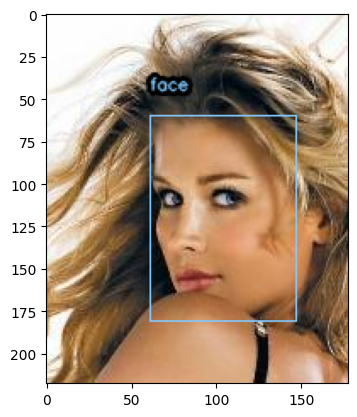

In [18]:
ADB_IMAGE_ID_VALUE="c5f7ccd9742948efa10ea279bb0848d1"
display_limit = 5
query = [ {
        "FindImage": {
            "_ref": 1,
            "blobs": True,
            "constraints": {
                "adb_image_id" : ["==", ADB_IMAGE_ID_VALUE]
            },
            "results": {
                "all_properties": True
            }
        }
    }, {
        "FindBoundingBox": {
             "is_connected_to": {
                "ref": 1
            },
            "with_label": "face",
            "labels": True,
            "coordinates": True,
            "uniqueids": True
        }
    }
   ]

bbox_uniqueid = None
response, blobs = client.query(query)
print(f"Bounding Box Data = {response[1]}")
if isinstance(response,list) and response[0]["FindImage"]["returned"] > 0:
   imgs = Images(client, batch_size= display_limit, response=response[0]["FindImage"]["entities"])
   imgs.display( show_bboxes= True)
   bbox_uniqueid = response[1]["FindBoundingBox"]["entities"][0]["_uniqueid"]
   print(f"Unique Id for face bounding box for {ADB_IMAGE_ID_VALUE} is {bbox_uniqueid}")
else:
    print("No Images returned")


Once you have retrieved the image you are looking for, proceed to [retrieveing the Descriptor](#retrieve-descriptor).

<a id="ingested-bucket"></a>
## Select an Image from a Bucket Ingest

### Setup

Before running this portion of the notebook, make sure the following prerequisites are met:

1. Images in ApertureDB  
   Ensure your ApertureDB cloud instance contains images. You can ingest images using supported workflows such as the "[Ingest_from_Bucket](https://docs.aperturedata.dev/workflows/ingest_from_bucket)" which allows importing data directly from AWS or GCP storage.
2. Face Detection with Embeddings  
   Run the [face detection workflow](https://docs.aperturedata.io/workflows/face_detection) with "Extract embeddings" option enabled.
   This step is essential for performing similarity searches based on facial features.


### Retrieve the unique id for an Image

After running the ingest from bucket workflow, each image is assigned a unique **wf_sha1_hash** value, which can be used as an image identifier. This can be used to locate the bounding box which the facedetect workflow creates.

Using the ApertureDB Web UI, you can view the images, their associated metadata properties and the linked bounding boxes.

To locate the bounding box for a specific image:
1. Search for the image using appropriate **constraints** based on metadata or hash values.
2. Use the **FindBoundingBox** command with the **is_connected_to** parameter to retrieve bounding boxes associated with the target images.
3. If multiple bounding boxes are returned, refer to the **coordinates**, **width**, and **height** to identify the bounding box of interest.

After you've done that, put the **wf_sha1_hash** identifier in the **IMAGE_SHA1_ID** below. If there are multiple bounding boxes, you can pick the face of interest below.



In [6]:

IMAGE_SHA1_ID=

display_limit = 5
query = [ {
        "FindImage": {
            "_ref": 1,
            "blobs": True,
            "constraints": {
                "wf_sha1_hash" : ["==", IMAGE_SHA1_ID]
            },
            "results": {
                "all_properties": True
            }
        }
    }, {
        "FindBoundingBox": {
             "is_connected_to": {
                "ref": 1
            },
            "with_label": "face",
            "labels": True,
            "coordinates": True,
            "uniqueids": True
        }
    }
   ]

bbox_uniqueid = None
bbox_data = None
response, blobs = client.query(query)
print(f"Bounding Box Data = {response[1]}")
if isinstance(response,list) and response[0]["FindImage"]["returned"] > 0:
   imgs = Images(client, batch_size= display_limit, response=response[0]["FindImage"]["entities"])
   imgs.display( show_bboxes= True)
   bbox_data = response[1]["FindBoundingBox"]["entities"]
   if len(bbox_data) == 1:
       print("Only one face detected. Selected as the target.")
       bbox_uniqueid = bbox_data[0]["_uniqueid"]
       print(f"Unique Id for face bounding box for {ADB_IMAGE_ID_VALUE} is {bbox_uniqueid}")
   else:
       print("Multiple faces detected. Faces follow:")
       for num,face in enumerate(bbox_data):
           print(f"Face #{num}: {face}")
       print("Please select the target face below")
   
   
else:
    print("No Images returned")


{'FindBoundingBox': {'returned': 0, 'status': 0}}
No Images returned


If multiple faces were detected above, run the below code after putting the number listed about in `TARGET_FACE_NUMBER`

In [ ]:
TARGET_FACE_NUMBER=10000

if bbox_uniqueid is None:
    if bbox_data is None:
        print("No Bounding Box data, please run the code above and ensure an image is returned.")
    elif TARGET_FACE_NUMBER == 10000:
        print("Please ensure to set TARGET_FACE_NUMBER to a valid face number")
    else:
        bbox_uniqueid = bbox_data[TARGET_FACE_NUMBER]["_uniqueid"]
else:
    print("Bounding box target is already found, skipping assignment")

<a id="retrieve-descriptor"></a>

## Retrieving the Descriptor(Embedding) for the Target Face Bounding Box

Now that you have identifed the **_uniqueid** of the bounding box corresponding to the target face, you will use the **FindDescriptor** command with the **is_connected_to** parameter to retrieve its associated descriptor(embedding).

In [28]:
query = [ {
        "FindBoundingBox": {
            "_ref": 1,
            "constraints": {
                "_uniqueid" : ["==", bbox_uniqueid ]
            }
        }
    }, {
        "FindDescriptor": {
             "is_connected_to": {
                "ref": 1
            },
            "blobs": True,
            "results": {
                "all_properties": True
            }
        }
    }
   ]

response, face_blobs = client.query(query)
if client.last_query_ok() and response[1]["FindDescriptor"]["returned"] > 0 :
    print(f"Descriptor found for bounding box {bbox_uniqueid}")
    print(response[1])
else:
    print(f"No Descriptor found for bounding box {bbox_uniqueid}")

Descriptor found for bounding box 1.17705.25680
{'FindDescriptor': {'blobs_start': 0, 'entities': [{'_blob_index': 0, '_set_name': 'wf_facenet_processed', '_uniqueid': '3.406491.25680'}], 'returned': 1, 'status': 0}}


## Find images containing a person with a similar face.
Once we’ve identified the descriptor corresponding to the face we want to search for, we’ll use it to perform a similarity search and find photos containing similar faces.
The descriptors generated through the face detection workflow are stored in the **wf_facenet_processed** DescriptorSet.
Using the **FindDescriptor** command, we’ll search for the 5 nearest neighbors of the given descriptor within the wf_facenet_processed DescriptorSet. We’ll then retrieve and display the bounding boxes and images associated with those descriptors.
For more details on FindDescriptor, please refer to the [Descriptor Commands documentation](https://docs.aperturedata.dev/query_language/Reference/descriptor_commands/desc_commands/FindDescriptor).

face bounding boxes
images


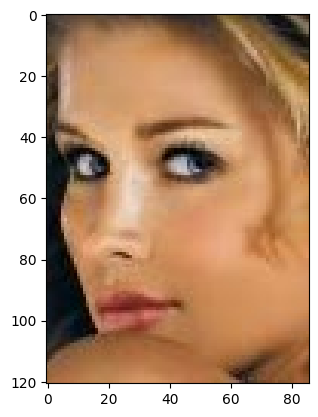

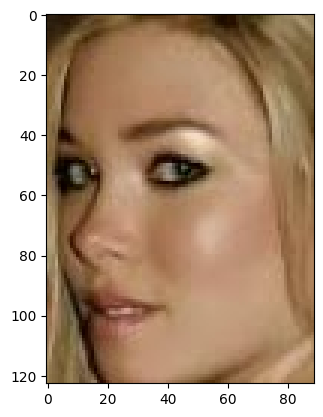

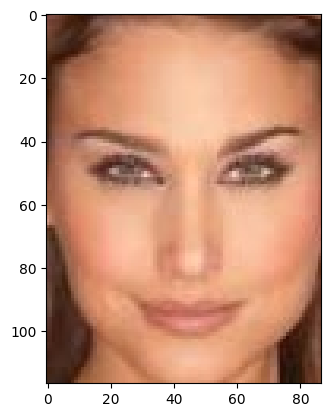

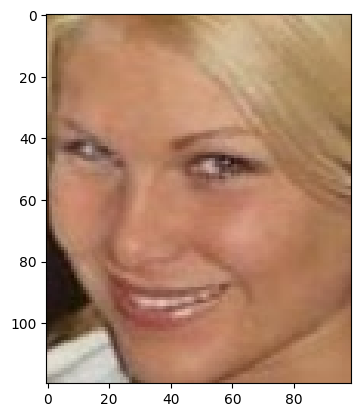

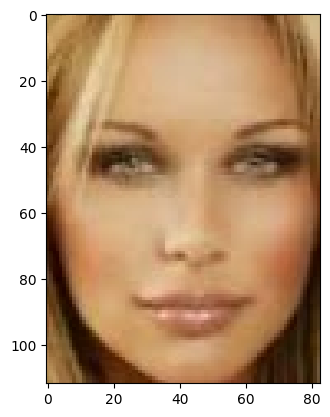

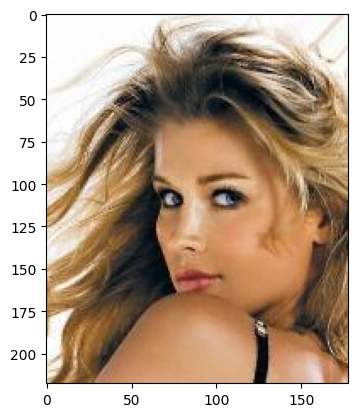

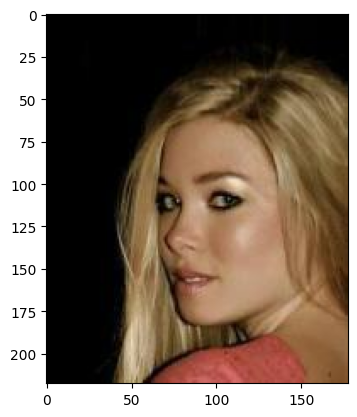

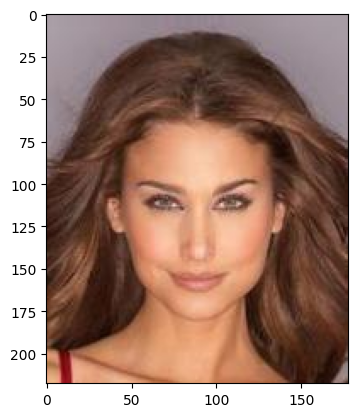

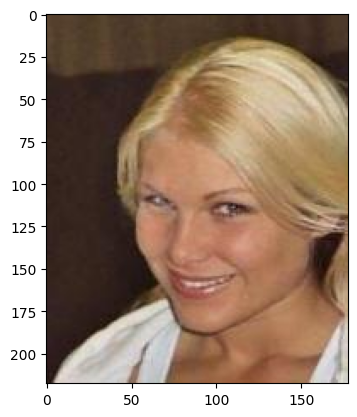

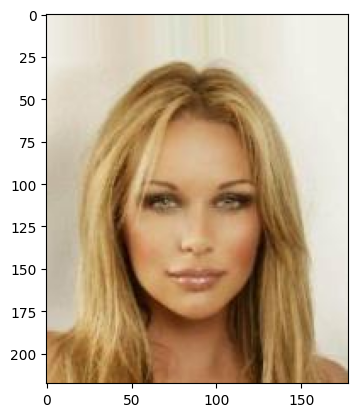

In [27]:
query = [ {
        "FindDescriptor": {
            "_ref": 1,
            "set": "wf_facenet_processed",
            "k_neighbors": 5,
            "distances": True,
        }
    }, {
        "FindBoundingBox": {
            "_ref" :2,
            "blobs": True,
             "is_connected_to": {
                "ref": 1
            },
            "results": {
                "all_properties": True
            }
        }
    }, {
        "FindImage": {
            "blobs": True,
            "is_connected_to": {
                "ref": 2
            },
            "results": {
                "list": ["wf_sha1_hash"]
            }
        }
    }]
response, blobs = client.query(query, face_blobs)
#print(response)

bbox_blobs = blobs[:5]
img_blobs = blobs[5:]
print("face bounding boxes")
display_images(bbox_blobs)

print("images")
display_images(img_blobs)


In [8]:
import os
for v in os.environ.keys():
    if not v.startswith("DB_"):
        continue
    print(f"- {v} = {os.environ[v]}")

- DB_HOST_PRIVATE = lenz
- DB_HOST_PUBLIC = wf-test4-hezxr0xd.farm0004.us-west1.gcp.aperturedata.dev
